# FORMATIVE ASSESSMENT OF ADOLESCENT GIRLS AND YOUNG WOMEN’S HIV, GENDER-BASED VIOLENCE AND SEXUAL AND REPRODUCTIVE HEALTH STATUS

## Background
Teenage pregnancy and motherhood have been a major health and social concern in Uganda as it infringes upon the human rights of girls but also hinders their ability to achieve their full socioeconomic development. Teenagers who engage in sexual intercourse at a young age face an elevated risk of becoming pregnant and giving birth. The 2022 UDHS indicated that 23.5% of women age 15-19 had initiated childbearing by the time of the survey, with 18.4% having already had a live birth, while 5.1% were pregnant with their first child.

Patterns by background characteristics:
* By age 16, 1 in every 10 women age 15-19 has begun childbearing. This percentage significantly rises to almost 4 out of every 10 by the time they reach 18 (Table 5.12).
* Teenagers in rural areas started childbearing earlier than those in urban areas. Twenty five percent of women age 15-19 in rural areas have begun childbearing, compared with 21% in urban areas.
* Teenage childbearing varies by region. The percentage of women age 15-19 who have begun childbearing ranges from 15% in Kigezi region to 28 % -30% in Busoga and Bukedi sub regions.
* The proportion of women age 15-19 who have begun childbearing decreases with both education and wealth.

Regions: The selection of the districts that we surveyed was informed by HIV prevalence dynamics and implementing partner support: we went to districts where there were Global Fund-supported implementing partners working to reduce the new number of new HIV infections among AGYW, improve SRH (e.g. reduce teenage pregnancy) and GBV indicators in the targeted districts.

## Data Processing

The output of this notebook includes four cleaned data frames, ready for further analysis.

## Load data

In [1]:
# Import libraries
import warnings
import os
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/teenage_pregnancy')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/teenage_pregnancy


## Data quality and description

In [3]:
# Load the Stata file (.dta)
df_load = pd.read_stata("./data/AGYW_dataset_for_UNICEF.dta")

df_load.columns = df_load.columns.str.lower() # standardize columns

df_load = df_load.dropna(axis=1, how='all') # drop null columns
df_load = df_load.drop(columns=df_load.loc[:, 'force_threat':'useful_item'].columns)
df_load = df_load.drop(columns=['continues', 'district_code'])
df_load = df_load.dropna(subset=['been_preg'])

df_load.head()

,uniquekey,part_number,school_name,date,scol_status,scol_own,scol_location,locate_other,scol_level,born_month,...,hivresult,regionstudy,regionubos,agegroup,syphilis,district,pop_nf_1024,sam_nf_1024,pon_nfagegrp,sam_nfagegrp
0,358,01128,ABARLER P/S (01),2018-08-07 00:00:00,In school,1.00,2.00,,1.00,10.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
1,466,01150,ABERLER PRIMARY SCHOOL (01),2018-08-07 00:00:00,In school,1.00,2.00,,1.00,10.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
2,385,01135,ABALER PRIMARY SCHOOL(01),2018-08-07 00:00:00,In school,1.00,2.00,,1.00,7.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
3,381,01350,,2018-08-15 00:00:00,Out of school,NaN,NaN,,4.00,98.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59
4,456,01124,ABERLER PRIMARY SCHOOL (01),2018-08-07 00:00:00,In school,1.00,1.00,,1.00,5.00,...,0,Northern1,Acholi,10-14,0.00,Amolatar,28759,418,11404,59


In [6]:
total = df_load['been_preg'].shape[0]
count = (df_load['been_preg'] == 1).sum()
print(f"The raw dataset contains responses from {total} girls (10-24) of which {count} have experienced pregnancy.")

The raw dataset contains responses from 8076 girls (10-24) of which 2345 have experienced pregnancy.


In [7]:
columns = [# Age
            'born_year', 'born_month', 'age_completed',

           # School attendance
           'scol_status', 'attend_scol', 'scol_level',
           'lack_fees', 'got_preg', 'got_married', 'got_sick', 'need_money', 'good_std', 'int_scol',

           # Marital status
           'current_married', 'age_marry',
           
           # Household vulnerability 
           'source_water', 'type_toilet', 'highest_educ', 'enough_food', 'consult_spirit',
           'sick_adult', 'severe_disable', 'child_enrol', 'care_orphan',
            
            # Wealth tertile
            'radio', 'tv_set', 'bicycle', 'motorcycle', 'own_home', 'cell_phone',
           'reg_phone', 'computer', 'income_busin', 'bath_room', 'run_water',
           'electricity', 'car', 'generator', 'solar',

            # Sex and pregnancy
           'life_sex', 'will_sex', 'person_sex', 'do_anything', 'under_influe',
            'been_preg', 'age_preg', 'sex_age','preg_end',
            'male_condom', 'female_condom', 'iud_coil', 'pill', 'withdrawal', 'implant', 'injection', 'emergency',

            # Services 
           'preg_anten', 'numb_times', 'visit_clinic', 'didnt_attend', 'last_deliv', 'had_abort']

df_clean = df_load[columns].copy()  

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8076 entries, 0 to 8235
Data columns (total 62 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   born_year        8020 non-null   float64 
 1   born_month       8018 non-null   float64 
 2   age_completed    8076 non-null   int16   
 3   scol_status      8076 non-null   category
 4   attend_scol      8070 non-null   category
 5   scol_level       4207 non-null   float64 
 6   lack_fees        3462 non-null   float64 
 7   got_preg         2162 non-null   float64 
 8   got_married      1981 non-null   float64 
 9   got_sick         1839 non-null   float64 
 10  need_money       1854 non-null   float64 
 11  good_std         1845 non-null   float64 
 12  int_scol         1762 non-null   float64 
 13  current_married  8076 non-null   category
 14  age_marry        1658 non-null   float64 
 15  source_water     2129 non-null   float64 
 16  type_toilet      1994 non-null   float64 
 17  

## Recoding

Q.1001 Have you ever been pregnant and gave birth to a baby? [been_preg]

Q.401 Have you ever had any sexual intercourse in your life? (By this, I mean when a man or boy puts his penis in a woman or girl’s vagina) [life_sex]

Q.405 The first time you had sexual intercourse with someone; would you say you were willing, somewhat willing or not willing at all? Willing means you gave permission or said it was OK or that you did it because you wanted to and not because someone forced you to do it [will_sex]

In [10]:
# Been pregnant (1 = Yes, 0 = No) [1001]
df_clean['been_preg'] = df_clean['been_preg'].map({1.0: 1, 2.0: 0}).astype(int)

# Life sex (1 = Yes, 0 = No) [401]
df_clean['life_sex'] = df_clean['life_sex'].map({1.0: 1, 2.0: 0}).fillna(-1).astype(int) # fill na with -1 for now

# life_sex (correcting erorrs where life_sex is coded as -1)
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['life_sex'] == -1), 'life_sex'] = 1
df_clean.loc[(df_clean['been_preg'] == 0) & (df_clean['life_sex'] == -1), 'life_sex'] = 0
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['life_sex'] == 0), 'life_sex'] = 1

# Willingness to have sex [405]
df_clean['will_sex_binary'] = df_clean['will_sex'].map({1.0: 1, 
                                                        2.0: 0,
                                                        3.0: 0,
                                                        4.0: 0})

Q.intro SCHOOLING STATUS: 1…… IN-SCHOOL 2 ……. OUT OF SCHOOL [scol_status]

Q.103a Have you ever attended school? [atttend_scol]

Q.104c What are some of the main reasons you are not in school? (Select all that apply)

In [12]:
# If not in school and attend school is blank replace with never attended school [Intro Q]
df_clean.loc[(df_clean['scol_status'] == 'Out of school') & (df_clean['attend_scol'].isna()), 'attend_scol'] = 'No'

# Have you ever attended school? [103a]
df_clean['attend_scol_binary'] = df_clean['attend_scol'].map({'Yes':1,'No':0})

# Reasons for drop out [104c]
columns_to_encode = ['lack_fees', 'got_preg', 'got_married', 'got_sick', 'need_money', 'good_std', 'int_scol']
df_clean[columns_to_encode] = df_clean[columns_to_encode].fillna(0)
df_clean[columns_to_encode] = df_clean[columns_to_encode].map(lambda x: 1 if x == 1 else 0)

Q.107a Are you currently married? (by marriage I mean religious, traditional, civil or consensual union) [current_married]

In [14]:
# Marital status to binary numeric (1 = Married, 0 = Never Married) [107a]
df_clean['current_married_binary'] = df_clean['current_married'].map({
    'MARRIED/UNION': 1,
    'DIVORCED/SEPARATED':0,
    'WIDOWED':0,
    'NEVER MARRIED': 0,
    'IN RELATIONSHIP BUT NOT MARRIED': 0
})

# Marital history to binary numeric (1 = Been married, 0 = Never Married) [107a]
df_clean['been_married_binary'] = df_clean['current_married'].map({
    'MARRIED/UNION': 1,
    'DIVORCED/SEPARATED':1,
    'WIDOWED':1,
    'NEVER MARRIED': 0,
    'IN RELATIONSHIP BUT NOT MARRIED': 0
})

# Married before pregnancy
df_clean['pre_preg_marriage'] = np.where(df_clean['age_marry'] <= df_clean['age_preg'], 1, 0)

Q.1302 How many times have you sought services or information from a doctor or a nurse for these services in the last twelve months? [numb_times]

In [16]:
# Replace 0 with 1 since every individual is assumed to have visited at least once [1302]
df_clean['numb_times'] = df_clean['numb_times'].replace(0, 1)

# Compute the IQR to set an upper bound for outliers
q1 = df_clean['numb_times'].quantile(0.25)
q3 = df_clean['numb_times'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# Cap values above the upper bound to the upper bound value
df_clean['numb_times'] = df_clean['numb_times'].clip(upper=upper_bound)

Q.1101 How old were you when you first got married? [age_marry]

In [18]:
# Compute the IQR for age_marry
q1 = df_clean['age_marry'].quantile(0.25)
q3 = df_clean['age_marry'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower bound
lower_bound = q1 - 1.5 * iqr

# Cap values below the lower bound to the lower_bound value
df_clean['age_marry'] = df_clean['age_marry'].clip(lower=lower_bound)

Q.101 In what month and year were you born? [born_month]

Q.102 How old were you at your last birthday? [age_completed]

In [20]:
# If born_year is missing, estimate it using age_completed
df_clean.loc[df_clean['born_year'].isna(), 'born_year'] = 2018 - df_clean['age_completed']

# If born_month is missing, assume July as the midpoint of the year
df_clean.loc[df_clean['born_month'].isna(), 'born_month'] = 7

# Ensuring numeric dtypes
df_clean['born_month'] = pd.to_numeric(df_clean['born_month'], errors='coerce')  # Convert to numeric, set errors to NaN
df_clean['born_year'] = pd.to_numeric(df_clean['born_year'], errors='coerce')  # Convert to numeric

# Fix `born_month`: Keep only values between 1 and 12, replace others with NaN
df_clean.loc[~df_clean['born_month'].between(1, 12), 'born_month'] = np.nan

# Fix `born_year`: Keep only reasonable values (between 1993 and 2008)
df_clean.loc[~df_clean['born_year'].between(1993, 2008), 'born_year'] = np.nan

# Assume missing `born_month` is July (middle of the year)
df_clean['born_month'] = df_clean['born_month'].fillna(7)

# Calculate exact months lived by July 2018
df_clean['age_months'] = (2018 - df_clean['born_year']) * 12 + (7 - df_clean['born_month'])

# Making sure that the pregnancy age is between 10 and 24
df_clean.loc[~df_clean['age_preg'].between(10, 24), 'age_preg'] = np.nan

# Missing age_preg is replaced with current age minus 1 year
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['age_preg'].isna()), 'age_preg'] = df_clean['age_completed'] - 1

Q.402 How old were you when you had sexual intercourse for the very first time? [age_sex]

Q.1001 Have you ever been pregnant and gave birth to a baby? [been_preg]

Q.102 How old were you at your last birthday? [age_completed]

Q.1101 How old were you when you first got married? [age_marry]

Q.101 In what month and year were you born? [born_month]

In [22]:
# 1. Update 'been_preg' based on 'age_preg'
df_clean.loc[(df_clean['been_preg'] == 0) & (df_clean['age_preg'].notna()), 'been_preg'] = 1

# 2. Validate 'sex_age'
df_clean.loc[~df_clean['sex_age'].between(5, 24), 'sex_age'] = np.nan

# 3. Assign 'sex_age' where missing for pregnant individuals
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['sex_age'].isna()), 'sex_age'] = df_clean['age_preg']

# 4. Ensure 'sex_age' ≥ 'age_preg'
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['sex_age'] > df_clean['age_preg']), 'sex_age'] = df_clean['age_preg']

# 5. Ensure 'age_preg' ≤ 'age_completed'
df_clean.loc[(df_clean['been_preg'] == 1) & (df_clean['age_preg'] > df_clean['age_completed']), 'age_preg'] = df_clean['age_completed']

# 6. Ensure that 'age_marry' ≤ 'age_completed'
df_clean.loc[(df_clean['age_marry'] > df_clean['age_completed']), 'age_marry'] = df_clean['age_completed']

# 7. Update 'age_marry' based on 'been_married'
df_clean.loc[(df_clean['been_married_binary'] == 0) & (df_clean['age_marry'].notna()), 'age_marry'] = np.nan

# 8. Remove invalid 'age_preg' entries
df_clean = df_clean[(df_clean['age_preg'].isna()) | (df_clean['age_preg'] <= 25)].copy()

# 9. Calculate 'diff'
df_clean.loc[df_clean['been_preg'] == 1, 'diff'] = (df_clean['age_months'] / 12) - df_clean['age_preg']

# 10. Handle negative 'diff' values
df_clean.loc[df_clean['diff'] < -0.5, 'diff'] = np.nan

### Sample sizes for different subsetting

1. Sample 1 undercounts pregnancy events by excluding women who got pregnant as teens but are now older.
2. Sample 2 includes all teenage pregnancies (good), but compares them to girls who are still in the risk window—some of whom might yet become pregnant (so there’s censoring).
3. Sample 3 compares all teenage pregnancies to women who have passed through the risk window without becoming pregnant. This eliminates right‑censoring and gives you a non‑pregnant group whose “at‑risk” period is complete.

In [24]:
# Not been pregnant (currently 10-19) | Been pregnant (currently 10-19)
df_sample_1 = df_clean.loc[(df_clean['age_completed'] <= 19)]
df_sample_1.been_preg.value_counts()

been_preg
0    4216
1     629
Name: count, dtype: int64

In [25]:
# Not been pregnant (currently 10-19) | Been pregnant 10-19 (irrespective of current age)
df_sample_2 = df_clean.loc[
    ( (df_clean['been_preg'] == 1) & (df_clean['age_preg'] <= 19) )
    |
    ( (df_clean['been_preg'] == 0) & (df_clean['age_completed'] <= 19) )
]

df_sample_2['been_preg'].value_counts()

been_preg
0    4216
1    1925
Name: count, dtype: int64

In [26]:
# Never been pregnant (currently older than 19) | Been pregnant 10-19 (irrespective of current age)
df_sample_3 = df_clean.loc[
    ( (df_clean['been_preg'] == 1) & (df_clean['age_preg'] <= 19) )
    |
    ( (df_clean['been_preg'] == 0) & (df_clean['age_completed'] >= 20) )
]

df_sample_3['been_preg'].value_counts()

been_preg
1    1925
0    1513
Name: count, dtype: int64

## Creating categories

**Household Vulnerability**

Vulnerability was measured at the individual, household and community levels, following the steps outlined in the report entitled, The Adolescent Girls Vulnerability Index: Guiding Strategic Investment in Uganda.

For household level, a girl was considered vulnerable if she experienced any two of the following five conditions: no access to improved source of water, no access to improved sanitation, household head has no education, food insecurity (no access to food in a day), and non-family support (ever consulted others for social support other than a family member).

In [29]:
# Conditions met for HH vulnerability index
df_sample_3['pre_ques'] = df_sample_3.loc[:, 'sick_adult':'care_orphan'].apply(lambda row: (row == 1).sum(), axis=1)
df_sample_3['hh_vul'] = 0  # Default to 0 for all

# Only apply vulnerability conditions if pre_ques > 0
df_sample_3.loc[df_sample_3['pre_ques'] > 0, 'hh_vul'] = (
    (
        (df_sample_3['source_water'] == 3).astype(int) +  # No improved water
        (df_sample_3['type_toilet'] != 1).astype(int) +  # No improved sanitation
        (df_sample_3['highest_educ'].isna()).astype(int) +  # Household head has no education (skipped question)
        (df_sample_3['enough_food'] != 1).astype(int) +  # Food insecurity (at least 1 day without food)
        (df_sample_3['consult_spirit'] != 1).astype(int)  # Consulted non-family for social support
    ) >= 2  # If at least two conditions are met → Vulnerable (1), otherwise (0)
).astype(int)  # Ensure the column contains only 0s and 1s

# Tabulate population count
hh_vul_count = df_sample_3.groupby(['hh_vul', 'been_preg']).size().reset_index(name='count')
hh_vul_count['percentage'] = hh_vul_count['count'] / hh_vul_count.groupby('hh_vul')['count'].transform('sum') * 100
hh_vul_count

,hh_vul,been_preg,count,percentage
0,0,0,1323,43.75
1,0,1,1701,56.25
2,1,0,190,45.89
3,1,1,224,54.11


  Wealth Tertile  Count  Percentage
0            Low   1146       33.30
1         Medium   1147       33.40
2           High   1145       33.30


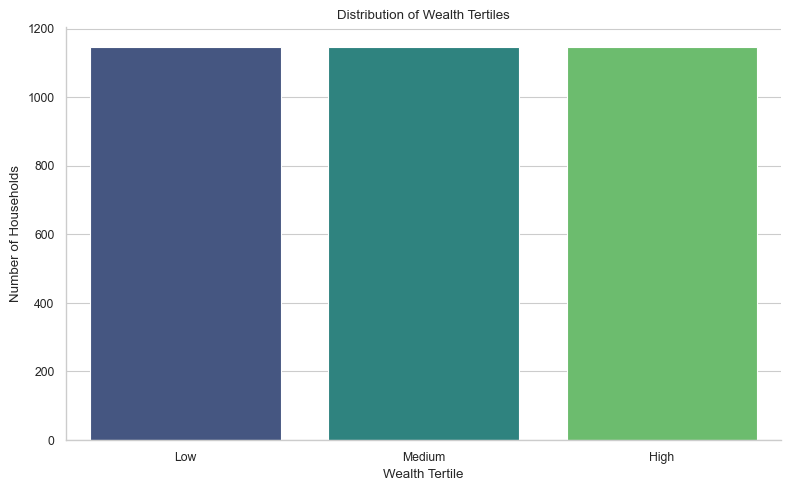

tv_set         0.41
electricity    0.38
run_water      0.37
bath_room      0.34
car            0.31
income_busin   0.27
computer       0.25
radio          0.22
cell_phone     0.19
motorcycle     0.18
generator      0.15
reg_phone      0.15
solar          0.13
bicycle        0.12
own_home       0.09
dtype: float64


In [30]:
# Wealth quintiles
asset_vars = ['radio',
              'tv_set',
              'bicycle',
              'motorcycle',
              'own_home',
              'cell_phone',
              'reg_phone',
              'computer',
              'income_busin',
              'bath_room',
              'run_water',
              'electricity',
              'car',
              'generator',
              'solar'
             ]

# Handle categorical responses: Replace '98' with NaN and convert to binary
df_assets = df_sample_3[asset_vars].replace(98, np.nan).copy()
df_assets = df_assets.map(lambda x: 1 if x == 1 else 0)

# Fill NaN with 0 (assuming lack of asset ownership if unsure)
df_assets = df_assets.fillna(0)

# Standardize the data
scaler = StandardScaler()
assets_scaled = scaler.fit_transform(df_assets)

# Apply PCA
pca = PCA(n_components=1)
wealth_index = pca.fit_transform(assets_scaled)

# Assign the first principal component as a flat array
df_sample_3['wealth_index'] = wealth_index[:, 0]

# Create wealth tertiles
df_sample_3['wealth_tertile'] = pd.qcut(df_sample_3['wealth_index'], 3, labels=['Low', 'Medium', 'High'])

df_sample_3['wealth_tertile'] = pd.Categorical(
    df_sample_3['wealth_tertile'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

# Summary table
wealth_summary = df_sample_3['wealth_tertile'].value_counts().sort_index().reset_index()
wealth_summary.columns = ['Wealth Tertile', 'Count']
wealth_summary['Percentage'] = (wealth_summary['Count'] / wealth_summary['Count'].sum() * 100).round(1)

print(wealth_summary)

# Visualize the Wealth Tertiles
plt.figure(figsize=(8, 5))
sns.countplot(x='wealth_tertile', data=df_sample_3, palette="viridis", hue='wealth_tertile')
plt.xlabel("Wealth Tertile")
plt.ylabel("Number of Households")
plt.title("Distribution of Wealth Tertiles")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('wealth_tertiles.png', dpi=300)
plt.show()

# Display PCA weights
wealth_weights = pd.Series(pca.components_[0], index=asset_vars)
print(wealth_weights.sort_values(ascending=False))

Socio-demographic profiles of girls who have experienced pregnancy and given birth by age cohort: Age 10 - 14 and Age 15 - 19

## Export

In [33]:
# Export as csv
df_sample_3.to_csv('./data/processed_df.csv', index=False)